In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

In [6]:
weathermob_data = torch.from_numpy(pd.read_csv("../../data/Covid_mob/Berlin_data/weather_mobility.csv", index_col=0).to_numpy(dtype=float)).float().reshape(-1, 2, 1)

In [13]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        
        # Define the first fully connected layer
        # input_size: Number of input features (e.g., S, I, R)
        # hidden_size: Number of neurons in the hidden layer
        self.fc1 = nn.Linear(input_size, hidden_size)
        
        # Define the activation function (ReLU)
        # ReLU: Rectified Linear Unit, introduces non-linearity
        self.relu = nn.ReLU()
        
        # Define the second fully connected layer
        # hidden_size: Number of neurons in the hidden layer
        # output_size: Number of output features (e.g., beta, gamma)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Pass input through the first fully connected layer
        out = self.fc1(x)
        
        # Apply the ReLU activation function
        out = self.relu(out)
        
        # Pass the result through the second fully connected layer
        out = self.fc2(out)
        
        return out

In [14]:
def sir_ode(y, t, beta, gamma):
    S, I, R = y
    dS_dt = -beta * S * I
    dI_dt = beta * S * I - gamma * I
    dR_dt = gamma * I
    return torch.tensor([dS_dt, dI_dt, dR_dt])

In [16]:
# Hyperparameters
input_size = 3  # S, I, R
hidden_size = 10
output_size = 2  # beta, gamma
learning_rate = 0.001
num_epochs = 1000

# Initialize the neural network, loss function, and optimizer
model = SimpleNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training data (example data)
S0, I0, R0 = 0.99, 0.01, 0.0  # Initial conditions
data = torch.tensor([[S0, I0, R0]], dtype=torch.float32, requires_grad=True)

# Training loop
for epoch in range(num_epochs):
    model.train()

    # Forward pass
    params = model(data)
    beta, gamma = params[0]

    # Compute the ODE
    y = data[0]
    t = 0  # Initial time
    y_pred = sir_ode(y, t, beta, gamma)

    # Compute the loss
    loss = criterion(y_pred, data[0])

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 0.3285
Epoch [200/1000], Loss: 0.3285
Epoch [300/1000], Loss: 0.3285
Epoch [400/1000], Loss: 0.3285
Epoch [500/1000], Loss: 0.3285
Epoch [600/1000], Loss: 0.3285
Epoch [700/1000], Loss: 0.3285
Epoch [800/1000], Loss: 0.3285
Epoch [900/1000], Loss: 0.3285
Epoch [1000/1000], Loss: 0.3285


In [17]:
# Training loop with gradient check
for epoch in range(num_epochs):
    model.train()

    # Forward pass
    params = model(data)
    beta, gamma = params[0]

    # Compute the ODE
    y = data[0]
    t = 0  # Initial time
    y_pred = sir_ode(y, t, beta, gamma)

    # Compute the loss
    loss = criterion(y_pred, data[0])

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()

    # Print gradients
    for name, param in model.named_parameters():
        if param.grad is not None:
            print(f'Gradient for {name}: {param.grad}')

    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 0.3285
Epoch [200/1000], Loss: 0.3285
Epoch [300/1000], Loss: 0.3285
Epoch [400/1000], Loss: 0.3285
Epoch [500/1000], Loss: 0.3285
Epoch [600/1000], Loss: 0.3285
Epoch [700/1000], Loss: 0.3285
Epoch [800/1000], Loss: 0.3285
Epoch [900/1000], Loss: 0.3285
Epoch [1000/1000], Loss: 0.3285


In [18]:
# Example tensor with requires_grad=True
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)

# Perform some operations
y = x + 2
z = y * y * 3

# Compute the mean
out = z.mean()

# Perform backpropagation
out.backward()

# Print gradients
print(x.grad)  # This will print the gradients of out with respect to x

tensor([ 6.,  8., 10.])


In [50]:
# SIR Model Fitting using PyTorch's torch.nn

# This notebook will demonstrate how to fit a Susceptible-Infected-Recovered (SIR) model to data using
# PyTorch's `torch.nn` module. The SIR model is a simple compartmental model used in epidemiology
# to describe the spread of a disease in a population.

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# 1. Define the SIR Model
def sir_model(S, I, beta, gamma):
    N = S + I
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# 2. Simulate Synthetic Data
def simulate_sir(S0, I0, R0, beta, gamma, days):
    S, I, R = S0, I0, R0
    S_data, I_data, R_data = [S], [I], [R]
    
    for _ in range(1, days):
        dSdt, dIdt, dRdt = sir_model(S, I, beta, gamma)
        S += dSdt
        I += dIdt
        R += dRdt
        S_data.append(S)
        I_data.append(I)
        R_data.append(R)
        
    return np.array(S_data), np.array(I_data), np.array(R_data)

# Initial conditions and parameters
S0 = 999.0  # Initial susceptible population
I0 = 1.0    # Initial infected population
R0 = 0.0    # Initial recovered population
beta_true = 0.3
gamma_true = 0.1
days = 160

# Simulate data
S_data, I_data, R_data = simulate_sir(S0, I0, R0, beta_true, gamma_true, days)

# # Plot the simulated data
# plt.figure(figsize=(10,6))
# plt.plot(I_data, label='Infected')
# plt.plot(S_data, label='Susceptible')
# plt.plot(R_data, label='Recovered')
# plt.xlabel('Days')
# plt.ylabel('Population')
# plt.title('Simulated SIR Model Data')
# plt.legend()
# plt.show()

# 3. Define the Neural Network Model
class SIRNetwork(nn.Module):
    def __init__(self):
        super(SIRNetwork, self).__init__()
        self.beta = nn.Parameter(torch.tensor(0.1))  # Initialize beta
        self.gamma = nn.Parameter(torch.tensor(0.1))  # Initialize gamma
        
    def forward(self, S0, I0, R0, days):
        S, I, R = S0, I0, R0
        S_pred, I_pred, R_pred = [S], [I], [R]
        
        for _ in range(1, days):
            dSdt, dIdt, dRdt = sir_model(S, I, self.beta, self.gamma)
            S = S + dSdt
            I = I + dIdt
            R = R + dRdt
            S_pred.append(S)
            I_pred.append(I)
            R_pred.append(R)
        
        return torch.stack(S_pred), torch.stack(I_pred), torch.stack(R_pred)

# 4. Prepare the data for PyTorch
S_data_tensor = torch.tensor(S_data, dtype=torch.float32)
I_data_tensor = torch.tensor(I_data, dtype=torch.float32)
R_data_tensor = torch.tensor(R_data, dtype=torch.float32)

# 5. Instantiate and train the model
model = SIRNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    S_pred, I_pred, R_pred = model(S0, I0, R0, days)
    
    loss = criterion(I_pred, I_data_tensor)  # Using only the infected data for loss calculation
    
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

# 6. Plot the results
S_pred, I_pred, R_pred = model(S0, I0, R0, days)

plt.figure(figsize=(10,6))
plt.plot(I_data, label='True Infected', linestyle='dashed')
plt.plot(I_pred.detach().numpy(), label='Predicted Infected')
plt.plot(S_data, label='True Susceptible', linestyle='dashed')
plt.plot(S_pred.detach().numpy(), label='Predicted Susceptible')
plt.plot(R_data, label='True Recovered', linestyle='dashed')
plt.plot(R_pred.detach().numpy(), label='Predicted Recovered')
plt.xlabel('Days')
plt.ylabel('Population')
plt.title('Fitted SIR Model')
plt.legend()
plt.show()

# 7. Print learned parameters
print(f"Learned beta: {model.beta.item():.4f}")
print(f"Learned gamma: {model.gamma.item():.4f}")


TypeError: expected Tensor as element 0 in argument 0, but got float

In [51]:
print(f"Learned beta: {model.beta.item():.4f}")
print(f"Learned gamma: {model.gamma.item():.4f}")


Learned beta: 0.1000
Learned gamma: 0.1000


In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data from CSV file
data = pd.read_csv("../../data/Covid_raw/Berlin_data/data_short.csv", index_col=0, parse_dates=True)

# Preprocess the data
# Combine exposed and infected into a single 'infected' variable
data['infected'] = data['exposed']

# Combine recovered and deceased into a single 'recovered' variable
data['recovered'] = data['recovered'] + data['deceased']

# Drop unnecessary columns
data = data[['susceptible', 'infected', 'recovered']]

# Normalize the data
data[['susceptible', 'infected', 'recovered']] = data[['susceptible', 'infected', 'recovered']].astype(float)

# Define the SIR model
def sir_model(S, I, beta, gamma):
    N = S + I
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Define the neural network model
class SIRNetwork(nn.Module):
    def __init__(self):
        super(SIRNetwork, self).__init__()
        self.beta = nn.Parameter(torch.tensor(0.8))  # Initialize beta
        self.gamma = nn.Parameter(torch.tensor(0.01))  # Initialize gamma
        
    def forward(self, S0, I0, R0, days):
        S, I, R = S0, I0, R0
        S_pred, I_pred, R_pred = [S], [I], [R]
        
        for _ in range(1, days):
            dSdt, dIdt, dRdt = sir_model(S, I, self.beta, self.gamma)
            S = S + dSdt
            I = I + dIdt
            R = R + dRdt
            S_pred.append(S)
            I_pred.append(I)
            R_pred.append(R)
        
        return torch.stack(S_pred), torch.stack(I_pred), torch.stack(R_pred)

# Prepare the data for PyTorch
S_data_tensor = torch.tensor(data['susceptible'].values, dtype=torch.float32)
I_data_tensor = torch.tensor(data['infected'].values, dtype=torch.float32)
R_data_tensor = torch.tensor(data['recovered'].values, dtype=torch.float32)

# Initial conditions
S0 = S_data_tensor[0]
I0 = I_data_tensor[0]
R0 = R_data_tensor[0]
days = len(data)

# Instantiate and train the model
model = SIRNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    S_pred, I_pred, R_pred = model(S0, I0, R0, days)
    
    loss = criterion(I_pred, I_data_tensor)  # Using only the infected data for loss calculation
    
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

Epoch 100/1000, Loss: 0.0000
Epoch 200/1000, Loss: 0.0000
Epoch 300/1000, Loss: 0.0000
Epoch 400/1000, Loss: 0.0000
Epoch 500/1000, Loss: 0.0000
Epoch 600/1000, Loss: 0.0000
Epoch 700/1000, Loss: 0.0000
Epoch 800/1000, Loss: 0.0000
Epoch 900/1000, Loss: 0.0000
Epoch 1000/1000, Loss: 0.0000


In [42]:
I_pred

tensor([1.5864e-06, 1.5511e-06, 1.5165e-06, 1.4828e-06, 1.4498e-06, 1.4175e-06,
        1.3860e-06, 1.3551e-06, 1.3250e-06, 1.2955e-06, 1.2666e-06, 1.2384e-06,
        1.2109e-06, 1.1839e-06, 1.1576e-06, 1.1318e-06, 1.1066e-06, 1.0820e-06,
        1.0579e-06, 1.0344e-06, 1.0113e-06, 9.8882e-07, 9.6682e-07, 9.4530e-07,
        9.2426e-07, 9.0368e-07, 8.8357e-07, 8.6390e-07, 8.4468e-07, 8.2588e-07,
        8.0749e-07, 7.8952e-07, 7.7195e-07, 7.5477e-07, 7.3797e-07, 7.2154e-07,
        7.0548e-07, 6.8978e-07, 6.7443e-07, 6.5942e-07, 6.4474e-07, 6.3039e-07,
        6.1636e-07, 6.0264e-07, 5.8923e-07, 5.7611e-07, 5.6329e-07, 5.5075e-07,
        5.3849e-07, 5.2651e-07, 5.1479e-07, 5.0333e-07, 4.9213e-07, 4.8117e-07,
        4.7046e-07, 4.5999e-07, 4.4975e-07, 4.3974e-07, 4.2996e-07, 4.2039e-07,
        4.1103e-07, 4.0188e-07, 3.9294e-07, 3.8419e-07, 3.7564e-07, 3.6728e-07,
        3.5910e-07, 3.5111e-07, 3.4330e-07, 3.3565e-07, 3.2818e-07, 3.2088e-07,
        3.1374e-07, 3.0675e-07, 2.9993e-

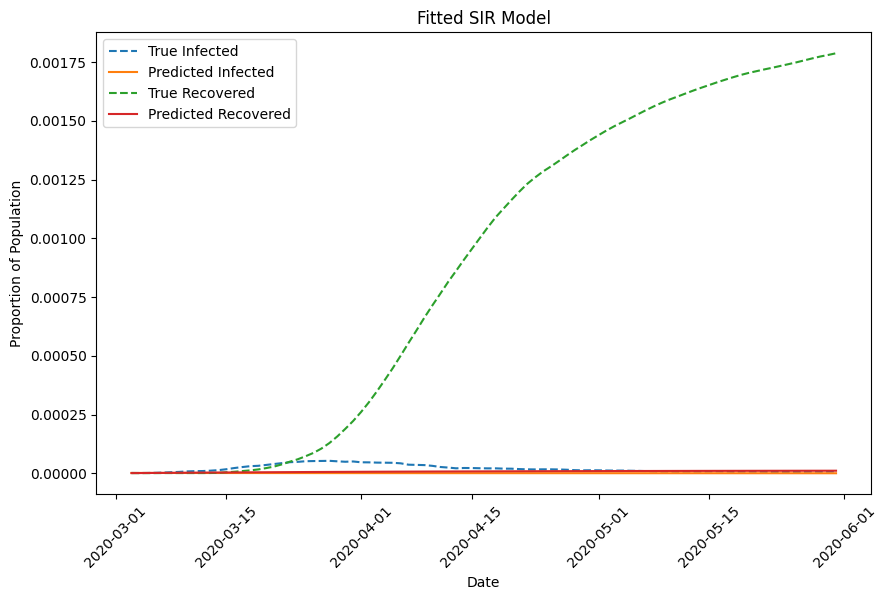

Learned beta: 0.1436
Learned gamma: 0.1658


In [43]:

# Plot the results
S_pred, I_pred, R_pred = model(S0, I0, R0, days)

plt.figure(figsize=(10,6))
plt.plot(data.index, I_data_tensor.numpy(), label='True Infected', linestyle='dashed')
plt.plot(data.index, I_pred.detach().numpy(), label='Predicted Infected')
plt.plot(data.index, R_data_tensor.numpy(), label='True Recovered', linestyle='dashed')
plt.plot(data.index, R_pred.detach().numpy(), label='Predicted Recovered')
plt.xlabel('Date')
plt.ylabel('Proportion of Population')
plt.title('Fitted SIR Model')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Print learned parameters
print(f"Learned beta: {model.beta.item():.4f}")
print(f"Learned gamma: {model.gamma.item():.4f}")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


# 1. Define the SIR Model
def sir_model(S, I, beta, gamma):
    N = S + I
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# 2. Simulate Synthetic Data for 90 Days
def simulate_sir(S0, I0, R0, beta, gamma, days):
    S, I, R = S0, I0, R0
    S_data, I_data, R_data = [S], [I], [R]
    
    for _ in range(1, days):
        dSdt, dIdt, dRdt = sir_model(S, I, beta, gamma)
        S += dSdt
        I += dIdt
        R += dRdt
        S_data.append(S)
        I_data.append(I)
        R_data.append(R)
        
    return np.array(S_data), np.array(I_data), np.array(R_data)

# Initial conditions and parameters
S0 = 999.0  # Initial susceptible population
I0 = 1.0    # Initial infected population
R0 = 0.0    # Initial recovered population
beta_true = 0.3
gamma_true = 0.1
days = 90  # Simulate for 90 days

# Simulate data
S_data, I_data, R_data = simulate_sir(S0, I0, R0, beta_true, gamma_true, days)

# Plot the simulated data
plt.figure(figsize=(10,6))
plt.plot(I_data, label='Infected')
plt.plot(S_data, label='Susceptible')
plt.plot(R_data, label='Recovered')
plt.xlabel('Days')
plt.ylabel('Population')
plt.title('Simulated SIR Model Data')
plt.legend()
plt.show()

/var/folders/lx/z16hcfq97pqgvr2c155lhvfh0000gn/T/ipykernel_2034/2230893406.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  S = torch.tensor(S0, dtype=torch.float32)
/var/folders/lx/z16hcfq97pqgvr2c155lhvfh0000gn/T/ipykernel_2034/2230893406.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  I = torch.tensor(I0, dtype=torch.float32)
/var/folders/lx/z16hcfq97pqgvr2c155lhvfh0000gn/T/ipykernel_2034/2230893406.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R = torch.tensor(R0, dtype=torch.float32)


Epoch 100/1000, Loss: 0.0000
Epoch 200/1000, Loss: 0.0000
Epoch 300/1000, Loss: 0.0000
Epoch 400/1000, Loss: 0.0000
Epoch 500/1000, Loss: 0.0000
Epoch 600/1000, Loss: 0.0000
Epoch 700/1000, Loss: 0.0000
Epoch 800/1000, Loss: 0.0000
Epoch 900/1000, Loss: 0.0000
Epoch 1000/1000, Loss: 0.0000


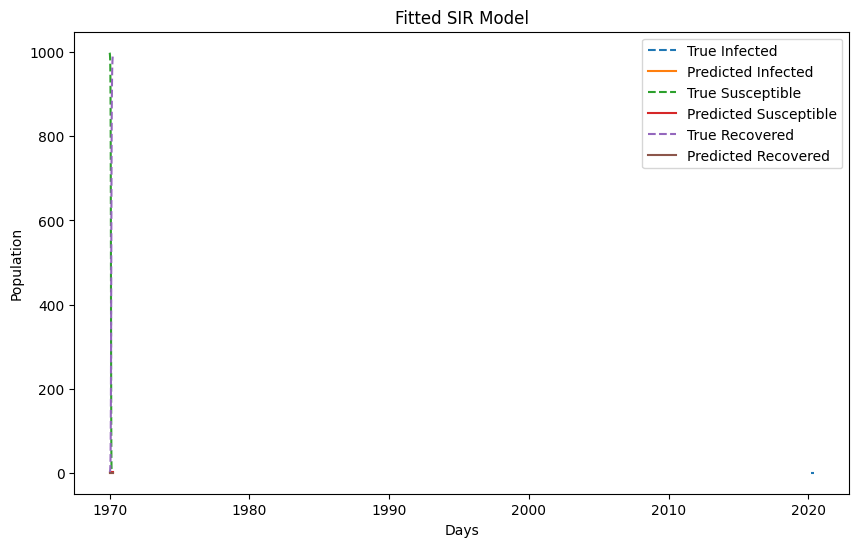

Learned beta: 0.1137
Learned gamma: 0.0864


In [72]:
# Load the data from CSV file
data = pd.read_csv("../../data/Covid_raw/Berlin_data/data_short.csv", index_col=0, parse_dates=True)

# Preprocess the data
# Combine exposed and infected into a single 'infected' variable
data['infected'] = data['exposed']

# Combine recovered and deceased into a single 'recovered' variable
data['recovered'] = data['recovered'] + data['deceased']

# Drop unnecessary columns
data = data[['susceptible', 'infected', 'recovered']]

# Normalize the data
data[['susceptible', 'infected', 'recovered']] = data[['susceptible', 'infected', 'recovered']].astype(float)

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
# Prepare the data for PyTorch
S_data_tensor = torch.tensor(data['susceptible'].values, dtype=torch.float32)
I_data_tensor = torch.tensor(data['infected'].values, dtype=torch.float32)
R_data_tensor = torch.tensor(data['recovered'].values, dtype=torch.float32)

# Initial conditions
S0 = S_data_tensor[0]
I0 = I_data_tensor[0]
R0 = R_data_tensor[0]
days = len(data)

# 3. Define the Neural Network Model
class SIRNetwork(nn.Module):
    def __init__(self):
        super(SIRNetwork, self).__init__()
        self.beta = nn.Parameter(torch.tensor(0.1))  # Initialize beta
        self.gamma = nn.Parameter(torch.tensor(0.1))  # Initialize gamma
        
    def forward(self, S0, I0, R0, days):
        # Convert initial conditions to tensors if they are not already
        S = torch.tensor(S0, dtype=torch.float32)
        I = torch.tensor(I0, dtype=torch.float32)
        R = torch.tensor(R0, dtype=torch.float32)
        
        S_pred, I_pred, R_pred = [S], [I], [R]
        
        for _ in range(1, days):
            dSdt, dIdt, dRdt = sir_model(S, I, self.beta, self.gamma)
            S = S + dSdt
            I = I + dIdt
            R = R + dRdt
            
            # Append tensors instead of floats
            S_pred.append(S)
            I_pred.append(I)
            R_pred.append(R)
        
        return torch.stack(S_pred), torch.stack(I_pred), torch.stack(R_pred)

# 5. Instantiate and train the model
model = SIRNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    S_pred, I_pred, R_pred = model(S0, I0, R0, days)  # Ensure days = 90 here
    
    loss = criterion(I_pred, I_data_tensor)  # Using only the infected data for loss calculation
    
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

# 6. Plot the results
S_pred, I_pred, R_pred = model(S0, I0, R0, days)  # Again, ensure days = 90

plt.figure(figsize=(10,6))
plt.plot(data.index, I_data_tensor.numpy(), label='True Infected', linestyle='dashed')
plt.plot(I_pred.detach().numpy(), label='Predicted Infected')
plt.plot(S_data, label='True Susceptible', linestyle='dashed')
plt.plot(S_pred.detach().numpy(), label='Predicted Susceptible')
plt.plot(R_data, label='True Recovered', linestyle='dashed')
plt.plot(R_pred.detach().numpy(), label='Predicted Recovered')
plt.xlabel('Days')
plt.ylabel('Population')
plt.title('Fitted SIR Model')
plt.legend()
plt.show()

# 7. Print learned parameters
print(f"Learned beta: {model.beta.item():.4f}")
print(f"Learned gamma: {model.gamma.item():.4f}")


In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data from CSV file with the date as the index
data = pd.read_csv("../../data/Covid_raw/Berlin_data/data_short.csv", index_col=0, parse_dates=True)

# Preprocess the data
# Combine exposed and infected into a single 'infected' variable (using 'exposed' as infected)
data['infected'] = data['exposed'] 

# Combine recovered and deceased into a single 'recovered' variable
data['recovered'] = data['recovered'] + data['deceased']

# Drop unnecessary columns
data = data[['susceptible', 'infected', 'recovered']]

# multiply by population size
data["susceptible"] = data["susceptible"] * 3769495
data["infected"] = data["infected"] * 3769495
data["recovered"] = data["recovered"] * 3769495

# Normalize the data if necessary (assuming data is already normalized if proportions are between 0 and 1)
data[['susceptible', 'infected', 'recovered']] = data[['susceptible', 'infected', 'recovered']].astype(float)

# Set the number of days
days = len(data)

# Prepare the data for PyTorch
S_data_tensor = torch.tensor(data['susceptible'].values, dtype=torch.float32)
I_data_tensor = torch.tensor(data['infected'].values, dtype=torch.float32)
R_data_tensor = torch.tensor(data['recovered'].values, dtype=torch.float32)

# Initial conditions based on the first row of the data
S0 = S_data_tensor[0]
I0 = I_data_tensor[0]
R0 = R_data_tensor[0]

weathermob_data = torch.from_numpy(pd.read_csv("../../data/Covid_mob/Berlin_data/weather_mobility.csv", index_col=0).to_numpy(dtype=float)).float().reshape(-1, 2, 1)

# Define the SIR model
def sir_model(S, I, beta, gamma):
    N = S + I
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Define the neural network model
class SIRNetwork(nn.Module):
    def __init__(self):
        super(SIRNetwork, self).__init__()
        self.beta = nn.Parameter(torch.tensor(0.1))  # Initialize beta
        self.gamma = nn.Parameter(torch.tensor(0.1))  # Initialize gamma
    def forward(self, S0, I0, R0, days, weathermob_data):
        # Convert initial conditions to tensors if they are not already, and ensure no gradients are tracked
        S = S0.clone().detach().float()
        I = I0.clone().detach().float()
        R = R0.clone().detach().float()
        
        S_pred, I_pred, R_pred = [S], [I], [R]
        for _ in range(1, days):
            
            beta = self.beta * weathermob_data[_-1][1]
            
            dSdt, dIdt, dRdt = sir_model(S, I, beta, self.gamma)
            S = S + dSdt
            I = I + dIdt
            R = R + dRdt
            
            # Append tensors instead of floats
            S_pred.append(S)
            I_pred.append(I)
            R_pred.append(R)
        
        return torch.stack(S_pred), torch.stack(I_pred), torch.stack(R_pred)

# Instantiate and train the model
model = SIRNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    S_pred, I_pred, R_pred = model(S0, I0, R0, days, weathermob_data)
    
    loss = criterion(I_pred, I_data_tensor)  # Using only the infected data for loss calculation
    
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

# Plot the results
S_pred, I_pred, R_pred = model(S0, I0, R0, days, weathermob_data)

plt.figure(figsize=(10,6))
plt.plot(data.index, I_data_tensor.numpy(), label='True Infected', linestyle='dashed')
plt.plot(data.index, I_pred.detach().numpy(), label='Predicted Infected')
plt.xlabel('Date')
plt.ylabel('Proportion of Population')
plt.title('Fitted SIR Model')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Print learned parameters
print(f"Learned beta: {model.beta.item():.4f}")
print(f"Learned gamma: {model.gamma.item():.4f}")


RuntimeError: stack expects each tensor to be equal size, but got [] at entry 0 and [1] at entry 1

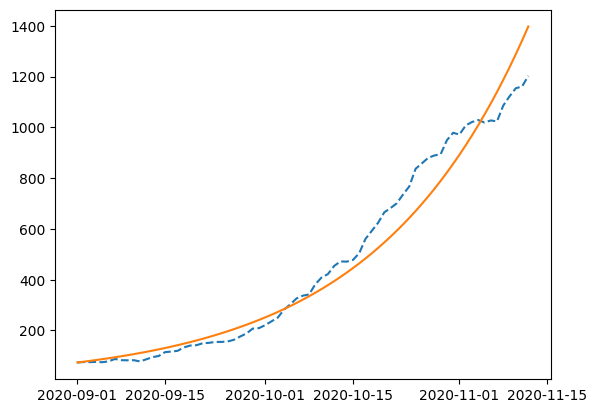

In [79]:
plt.plot(data.index, I_data_tensor.numpy(), label='True Infected', linestyle='dashed')
plt.plot(data.index, I_pred.detach().numpy(), label='Predicted Infected')

Population N is zero, causing division by zero
Loss is NaN at epoch: 8


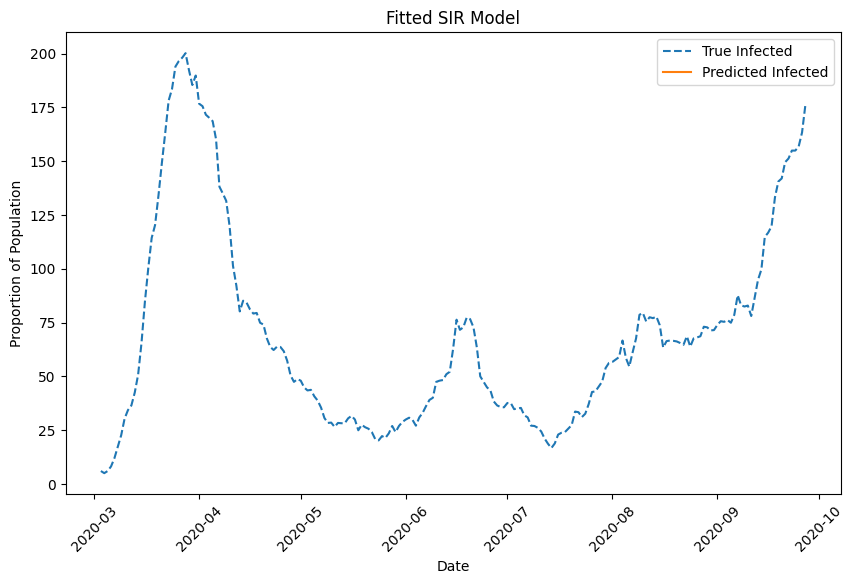

Learned beta: nan
Learned gamma: nan


In [105]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data from CSV file with the date as the index
data = pd.read_csv('../../data/Covid_raw/Berlin_data/data_short.csv', index_col=0, parse_dates=True)

# Preprocess the data
data['infected'] = data['exposed']
data['recovered'] = data['recovered'] + data['deceased']
data = data[['susceptible', 'infected', 'recovered']]
# multiply by population size
data["susceptible"] = data["susceptible"] * 3769495
data["infected"] = data["infected"] * 3769495
data["recovered"] = data["recovered"] * 3769495
data[['susceptible', 'infected', 'recovered']] = data[['susceptible', 'infected', 'recovered']].astype(float)

# Load weathermob_data
weathermob_data = torch.from_numpy(
    pd.read_csv('../../data/Covid_mob/Berlin_data/weather_mobility.csv', index_col=0).to_numpy(dtype=float)
).float().reshape(-1, 2)

# Set the number of days
days = len(data)

# Prepare the data for PyTorch
S_data_tensor = torch.tensor(data['susceptible'].values, dtype=torch.float32)
I_data_tensor = torch.tensor(data['infected'].values, dtype=torch.float32)
R_data_tensor = torch.tensor(data['recovered'].values, dtype=torch.float32)

# Initial conditions based on the first row of the data
S0 = S_data_tensor[0]
I0 = I_data_tensor[0]
R0 = R_data_tensor[0]

# Define the SIR model
def sir_model(S, I, beta, gamma):
    N = S + I
    if N == 0:
        print("Population N is zero, causing division by zero")
        return torch.tensor([0.0, 0.0, 0.0])
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Define the neural network model
class SIRNetwork(nn.Module):
    def __init__(self):
        super(SIRNetwork, self).__init__()
        self.beta1 = nn.Parameter(torch.tensor(0.001))  # Initialize beta
        self.beta2 = nn.Parameter(torch.tensor(0.001))  # Initialize beta
        self.gamma = nn.Parameter(torch.tensor(0.1))  # Initialize gamma

    def forward(self, S0, I0, R0, days, weathermob_data):
        S = S0.clone().detach().float()
        I = I0.clone().detach().float()
        R = R0.clone().detach().float()

        S_pred, I_pred, R_pred = [S], [I], [R]

        for t in range(1, days):
            beta = self.beta1 * weathermob_data[t-1, 0]**2 + self.beta2 * weathermob_data[t-1, 0]**2 * weathermob_data[t-1, 1]
            dSdt, dIdt, dRdt = sir_model(S, I, beta, self.gamma)
            S = S + dSdt
            I = I + dIdt
            R = R + dRdt

            S_pred.append(S)
            I_pred.append(I)
            R_pred.append(R)

        return torch.stack(S_pred), torch.stack(I_pred), torch.stack(R_pred)

# Instantiate and train the model
model = SIRNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    optimizer.zero_grad()

    S_pred, I_pred, R_pred = model(S0, I0, R0, days, weathermob_data)

    loss = criterion(I_pred, I_data_tensor)  # Using only the infected data for loss calculation
    data_tensor = torch.tensor(data.values, dtype=torch.float32)
    if torch.isnan(data_tensor).any():
        print("Input data contains NaN values")
        break
# Check for NaN values in the loss calculation
        # Ensure that the gradients are not exploding or vanishing
    for name, param in model.named_parameters():
        if param.grad is not None and torch.isnan(param.grad).any():
            print(f"Gradient for {name} contains NaN values at epoch:", epoch)
            break
    if torch.isnan(loss):
        print("Loss is NaN at epoch:", epoch)
        break
    
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

# Plot the results
S_pred, I_pred, R_pred = model(S0, I0, R0, days, weathermob_data)

plt.figure(figsize=(10,6))
plt.plot(data.index, I_data_tensor.numpy(), label='True Infected', linestyle='dashed')
plt.plot(data.index, I_pred.detach().numpy(), label='Predicted Infected')
plt.xlabel('Date')
plt.ylabel('Proportion of Population')
plt.title('Fitted SIR Model')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Print learned parameters
print(f"Learned beta: {model.beta1.item():.4f}")
print(f"Learned gamma: {model.gamma.item():.4f}")

Day 1, S: 3769488.25, I: 5.105350017547607, R: 3.587904930114746
Day 2, S: 3769488.5, I: 4.358743667602539, R: 4.098440170288086
Day 3, S: 3769488.75, I: 3.7213211059570312, R: 4.5343146324157715
Day 4, S: 3769489.0, I: 3.1771152019500732, R: 4.906446933746338
Day 5, S: 3769489.25, I: 2.712493896484375, R: 5.22415828704834
Day 6, S: 3769489.5, I: 2.3158187866210938, R: 5.495407581329346
Day 7, S: 3769489.5, I: 2.0223376750946045, R: 5.726989269256592
Day 8, S: 3769489.5, I: 1.7660490274429321, R: 5.92922306060791
Day 9, S: 3769489.5, I: 1.5422395467758179, R: 6.105827808380127
Day 10, S: 3769489.5, I: 1.3467931747436523, R: 6.260051727294922
Day 11, S: 3769489.5, I: 1.1761155128479004, R: 6.394731044769287
Day 12, S: 3769489.5, I: 1.0270676612854004, R: 6.51234245300293
Day 13, S: 3769489.5, I: 0.8969085216522217, R: 6.615049362182617
Day 14, S: 3769489.5, I: 0.7901678085327148, R: 6.704740047454834
Day 15, S: 3769489.5, I: 0.6961302757263184, R: 6.783756732940674
Day 16, S: 3769489.5,

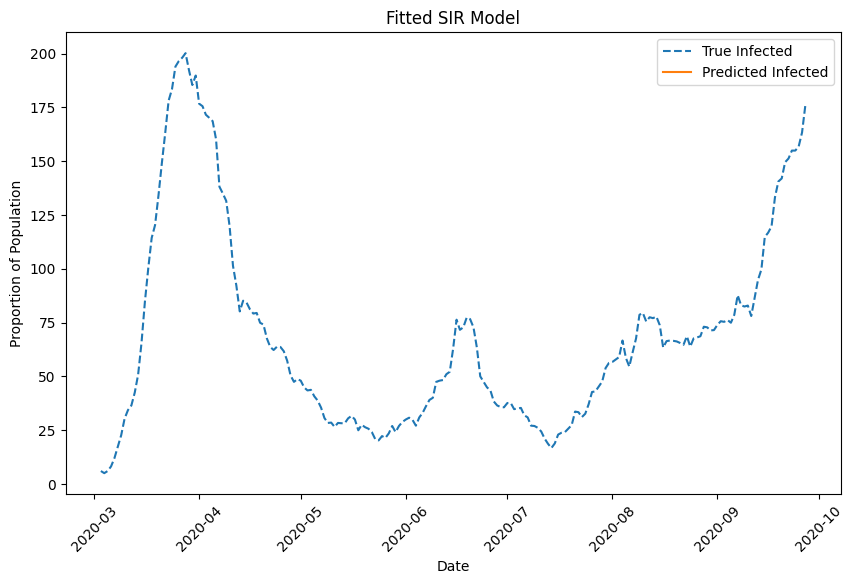

Learned beta: nan
Learned gamma: nan


In [113]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data from CSV file with the date as the index
data = pd.read_csv('../../data/Covid_raw/Berlin_data/data_short.csv', index_col=0, parse_dates=True)

# Preprocess the data
data['infected'] = data['exposed']
data['recovered'] = data['recovered'] + data['deceased']
data = data[['susceptible', 'infected', 'recovered']]
# multiply by population size
data["susceptible"] = data["susceptible"] * 3769495
data["infected"] = data["infected"] * 3769495
data["recovered"] = data["recovered"] * 3769495
data[['susceptible', 'infected', 'recovered']] = data[['susceptible', 'infected', 'recovered']].astype(float)

# Load weathermob_data
weathermob_data = torch.from_numpy(
    pd.read_csv('../../data/Covid_mob/Berlin_data/weather_mobility.csv', index_col=0).to_numpy(dtype=float)
).float().reshape(-1, 2)

# Set the number of days
days = len(data)

# Prepare the data for PyTorch
S_data_tensor = torch.tensor(data['susceptible'].values, dtype=torch.float32)
I_data_tensor = torch.tensor(data['infected'].values, dtype=torch.float32)
R_data_tensor = torch.tensor(data['recovered'].values, dtype=torch.float32)

# Initial conditions based on the first row of the data
S0 = S_data_tensor[0]
I0 = I_data_tensor[0]
R0 = R_data_tensor[0]

# Define the SIR model
# Define the SIR model with debug statements
# Define the SIR model with debug statements
def sir_model(S, I, beta, gamma):
    N = S + I
    if N == 0:
        print(f"Population N is zero, S: {S}, I: {I}")
        return torch.tensor([0.0, 0.0, 0.0])
    dSdt = -beta * S * I / (N + 1e-10)  # Add epsilon to prevent division by zero
    dIdt = beta * S * I / (N + 1e-10) - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Define the neural network model
class SIRNetwork(nn.Module):
    def __init__(self):
        super(SIRNetwork, self).__init__()
        self.beta1 = nn.Parameter(torch.tensor(0.001))  # Initialize beta
        self.beta2 = nn.Parameter(torch.tensor(0.001))  # Initialize beta
        self.gamma = nn.Parameter(torch.tensor(0.1))  # Initialize gamma

    def forward(self, S0, I0, R0, days, weathermob_data):
        S = S0.clone().detach().float()
        I = I0.clone().detach().float()
        R = R0.clone().detach().float()

        S_pred, I_pred, R_pred = [S], [I], [R]

        for t in range(1, days):
            beta = self.beta1 * weathermob_data[t-1, 0]**2 - self.beta2 * weathermob_data[t-1, 0]**2 * weathermob_data[t-1, 1]
            dSdt, dIdt, dRdt = sir_model(S, I, beta, self.gamma)
            S = torch.clamp(S + dSdt, min=0.0)
            I = torch.clamp(I + dIdt, min=0.0)
            R = torch.clamp(R + dRdt, min=0.0)

            # Debug statements to track values
            print(f"Day {t}, S: {S.item()}, I: {I.item()}, R: {R.item()}")  # Add this line to print values at each step
            if (S + I + R).item() == 0:
                print(f"Population is zero at day {t}, S: {S}, I: {I}, R: {R}")

            S_pred.append(S)
            I_pred.append(I)
            R_pred.append(R)

        return torch.stack(S_pred), torch.stack(I_pred), torch.stack(R_pred)

# Instantiate and train the model
model = SIRNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    optimizer.zero_grad()
    # Reset initial conditions
    S = S0.clone().detach().float()
    I = I0.clone().detach().float()
    R = R0.clone().detach().float()
    S_pred, I_pred, R_pred = model(S, I, R, days, weathermob_data)

    loss = criterion(I_pred, I_data_tensor)  # Using only the infected data for loss calculation
    data_tensor = torch.tensor(data.values, dtype=torch.float32)
    
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

# Plot the results
S_pred, I_pred, R_pred = model(S0, I0, R0, days, weathermob_data)

plt.figure(figsize=(10,6))
plt.plot(data.index, I_data_tensor.numpy(), label='True Infected', linestyle='dashed')
plt.plot(data.index, I_pred.detach().numpy(), label='Predicted Infected')
plt.xlabel('Date')
plt.ylabel('Proportion of Population')
plt.title('Fitted SIR Model')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Print learned parameters
print(f"Learned beta: {model.beta1.item():.4f}")
print(f"Learned gamma: {model.gamma.item():.4f}")

In [114]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data from CSV file with the date as the index
data = pd.read_csv('../../data/Covid_raw/Berlin_data/data_short.csv', index_col=0, parse_dates=True)

# Preprocess the data
data['infected'] = data['exposed']
data['recovered'] = data['recovered'] + data['deceased']
data = data[['susceptible', 'infected', 'recovered']]
data["susceptible"] = data["susceptible"] * 3769495
data["infected"] = data["infected"] * 3769495
data["recovered"] = data["recovered"] * 3769495
data[['susceptible', 'infected', 'recovered']] = data[['susceptible', 'infected', 'recovered']].astype(float)

# Load weathermob_data
weathermob_data = torch.from_numpy(
    pd.read_csv('../../data/Covid_mob/Berlin_data/weather_mobility.csv', index_col=0).to_numpy(dtype=float)
).float().reshape(-1, 2)

# Set the number of days
days = len(data)

# Prepare the data for PyTorch
S_data_tensor = torch.tensor(data['susceptible'].values, dtype=torch.float32)
I_data_tensor = torch.tensor(data['infected'].values, dtype=torch.float32)
R_data_tensor = torch.tensor(data['recovered'].values, dtype=torch.float32)

# Initial conditions based on the first row of the data
S0 = S_data_tensor[0]
I0 = I_data_tensor[0]
R0 = R_data_tensor[0]

# Define the SIR model with debug statements
def sir_model(S, I, beta, gamma):
    N = S + I
    if N == 0:
        print(f"Population N is zero, S: {S}, I: {I}")
        return torch.tensor([0.0, 0.0, 0.0])
    dSdt = -beta * S * I / (N + 1e-10)  # Add epsilon to prevent division by zero
    dIdt = beta * S * I / (N + 1e-10) - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Define the neural network model
class SIRNetwork(nn.Module):
    def __init__(self):
        super(SIRNetwork, self).__init__()
        self.beta1 = nn.Parameter(torch.tensor(0.001))  # Initialize beta
        self.beta2 = nn.Parameter(torch.tensor(0.001))  # Initialize beta
        self.gamma = nn.Parameter(torch.tensor(0.1))  # Initialize gamma

    def forward(self, S0, I0, R0, days, weathermob_data):
        S = S0.clone().detach().float()
        I = I0.clone().detach().float()
        R = R0.clone().detach().float()

        S_pred, I_pred, R_pred = [S], [I], [R]

        for t in range(1, days):
            beta = self.beta1 * weathermob_data[t-1, 0]**2 + self.beta2 * weathermob_data[t-1, 0]**2 * weathermob_data[t-1, 1]
            dSdt, dIdt, dRdt = sir_model(S, I, beta, self.gamma)
            S = torch.clamp(S + dSdt, min=0.0)
            I = torch.clamp(I + dIdt, min=0.0)
            R = torch.clamp(R + dRdt, min=0.0)

            # Debug statements to track values
            print(f"Day {t}, S: {S.item()}, I: {I.item()}, R: {R.item()}")
            if torch.isnan(S) or torch.isnan(I) or torch.isnan(R):
                print(f"NaN detected at day {t}, S: {S}, I: {I}, R: {R}")
                break

            S_pred.append(S)
            I_pred.append(I)
            R_pred.append(R)

        return torch.stack(S_pred), torch.stack(I_pred), torch.stack(R_pred)

# Instantiate and train the model
model = SIRNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Reset initial conditions
    S = S0.clone().detach().float()
    I = I0.clone().detach().float()
    R = R0.clone().detach().float()

    S_pred, I_pred, R_pred = model(S, I, R, days, weathermob_data)

    loss = criterion(I_pred, I_data_tensor)  # Using only the infected data for loss calculation

    if torch.isnan(loss):
        print("Loss is NaN at epoch:", epoch)
        break

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

# Plot the results
S_pred, I_pred, R_pred = model(S0, I0, R0, days, weathermob_data)

plt.figure(figsize=(10,6))
plt.plot(data.index, I_data_tensor.numpy(), label='True Infected', linestyle='dashed')
plt.plot(data.index, I_pred.detach().numpy(), label='Predicted Infected')
plt.xlabel('Date')
plt.ylabel('Proportion of Population')
plt.title('Fitted SIR Model')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Print learned parameters
print(f"Learned beta: {model.beta1.item():.4f}")
print(f"Learned gamma: {model.gamma.item():.4f}")

Day 1, S: 3769487.25, I: 6.2113800048828125, R: 3.587904930114746
Day 2, S: 3769486.5, I: 6.451883316040039, R: 4.209043025970459
Day 3, S: 3769485.5, I: 6.7016987800598145, R: 4.854231357574463
Day 4, S: 3769484.5, I: 6.96118688583374, R: 5.5244011878967285
Day 5, S: 3769483.5, I: 7.230722427368164, R: 6.22052001953125
Day 6, S: 3769482.5, I: 7.5106940269470215, R: 6.943592071533203
Day 7, S: 3769482.0, I: 7.361881256103516, R: 7.694661617279053
Day 8, S: 3769481.5, I: 7.21601676940918, R: 8.4308500289917
Day 9, S: 3769481.0, I: 7.073042869567871, R: 9.152451515197754
Day 10, S: 3769480.5, I: 6.932901382446289, R: 9.859755516052246
Day 11, S: 3769480.0, I: 6.795536994934082, R: 10.553045272827148
Day 12, S: 3769479.5, I: 6.66089391708374, R: 11.232599258422852
Day 13, S: 3769479.0, I: 6.528918743133545, R: 11.898688316345215
Day 14, S: 3769478.75, I: 6.2483625411987305, R: 12.551580429077148
Day 15, S: 3769478.5, I: 5.979862213134766, R: 13.176416397094727
Day 16, S: 3769478.25, I: 5.

/Users/inanb/Documents/GitHub/NeuralABM/.venv/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([209])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

Loss is NaN at epoch: 8


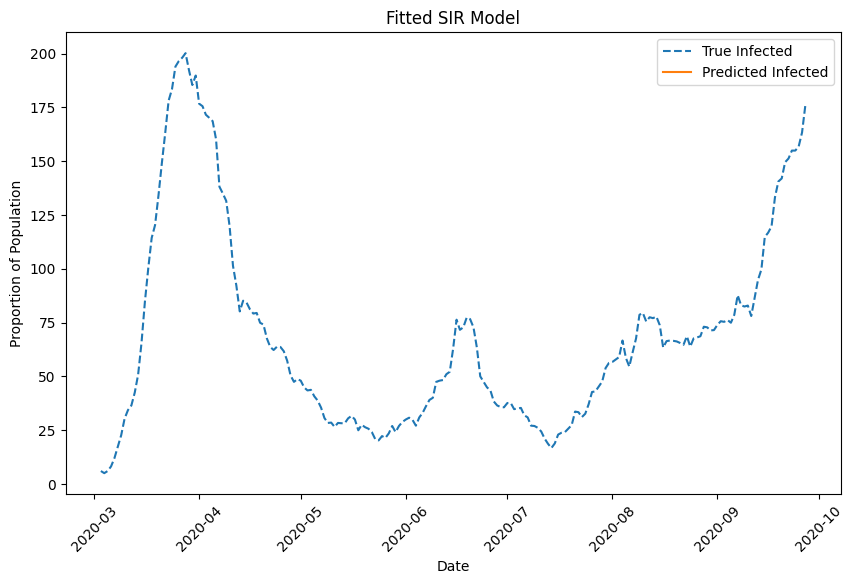

Learned beta: nan
Learned gamma: nan


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data from CSV file with the date as the index
data = pd.read_csv('../../data/Covid_raw/Berlin_data/data_short.csv', index_col=0, parse_dates=True)

# Preprocess the data
data['infected'] = data['exposed']
data['recovered'] = data['recovered'] + data['deceased']
data = data[['susceptible', 'infected', 'recovered']]
data["susceptible"] = data["susceptible"] * 3769495
data["infected"] = data["infected"] * 3769495
data["recovered"] = data["recovered"] * 3769495
data[['susceptible', 'infected', 'recovered']] = data[['susceptible', 'infected', 'recovered']].astype(float)

# Load weathermob_data
weathermob_data = torch.from_numpy(
    pd.read_csv('../../data/Covid_mob/Berlin_data/weather_mobility.csv', index_col=0).to_numpy(dtype=float)
).float().reshape(-1, 2)

# Set the number of days
days = len(data)

# Prepare the data for PyTorch
S_data_tensor = torch.tensor(data['susceptible'].values, dtype=torch.float32)
I_data_tensor = torch.tensor(data['infected'].values, dtype=torch.float32)
R_data_tensor = torch.tensor(data['recovered'].values, dtype=torch.float32)

# Initial conditions based on the first row of the data
S0 = S_data_tensor[0]
I0 = I_data_tensor[0]
R0 = R_data_tensor[0]

# Define the SIR model with debug statements
def sir_model(S, I, beta, gamma):
    N = S + I
    if N == 0:
        return torch.tensor([0.0, 0.0, 0.0])
    dSdt = -beta * S * I / (N + 1e-10)  # Add epsilon to prevent division by zero
    dIdt = beta * S * I / (N + 1e-10) - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Define the neural network model
class SIRNetwork(nn.Module):
    def __init__(self):
        super(SIRNetwork, self).__init__()
        self.beta1 = nn.Parameter(torch.tensor(0.001))  # Initialize beta
        self.beta2 = nn.Parameter(torch.tensor(0.001))  # Initialize beta
        self.gamma = nn.Parameter(torch.tensor(0.1))  # Initialize gamma

    def forward(self, S0, I0, R0, days, weathermob_data):
        S = S0.clone().detach().float()
        I = I0.clone().detach().float()
        R = R0.clone().detach().float()

        S_pred, I_pred, R_pred = [S], [I], [R]

        for t in range(1, days):
            beta = self.beta1 * weathermob_data[t-1, 0]**2 + self.beta2 * weathermob_data[t-1, 0]**2 * weathermob_data[t-1, 1]
            dSdt, dIdt, dRdt = sir_model(S, I, beta, self.gamma)
            S = torch.clamp(S + dSdt, min=0.0)
            I = torch.clamp(I + dIdt, min=0.0)
            R = torch.clamp(R + dRdt, min=0.0)

            S_pred.append(S)
            I_pred.append(I)
            R_pred.append(R)

        return torch.stack(S_pred), torch.stack(I_pred), torch.stack(R_pred)

# Instantiate and train the model
model = SIRNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Reset initial conditions
    S = S0.clone().detach().float()
    I = I0.clone().detach().float()
    R = R0.clone().detach().float()

    S_pred, I_pred, R_pred = model(S, I, R, days, weathermob_data)

    # Ensure the predicted and target tensors have the same size
    I_pred = I_pred.view(-1)
    I_data_tensor = I_data_tensor.view(-1)

    loss = criterion(I_pred, I_data_tensor)  # Using only the infected data for loss calculation

    if torch.isnan(loss):
        print("Loss is NaN at epoch:", epoch)
        break

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

# Plot the results
S_pred, I_pred, R_pred = model(S0, I0, R0, days, weathermob_data)

plt.figure(figsize=(10,6))
plt.plot(data.index, I_data_tensor.numpy(), label='True Infected', linestyle='dashed')
plt.plot(data.index, I_pred.detach().numpy(), label='Predicted Infected')
plt.xlabel('Date')
plt.ylabel('Proportion of Population')
plt.title('Fitted SIR Model')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Print learned parameters
print(f"Learned beta: {model.beta1.item():.4f}")
print(f"Learned gamma: {model.gamma.item():.4f}")